# generate all sorts of ratings for a Bundesliga result dataset

This code is a bit unstructured due to the fact that I was adding functions as I needed them - typical notebook workflow. I hope it will still be of some help as an example of how to apply the libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import datetime
%matplotlib inline

from elo import Elo as ELO
from glicko2 import Glicko2 as GLICKO
import trueskill as ts

In [2]:
# source https://www.kaggle.com/thefc17/bundesliga-results-19932018/version/1
bl = pd.read_csv('Bundesliga_Results.csv', parse_dates=['Date'])

This dataset contains results from every Bundesliga match from 1993-1994 to 2017-2018. It also includes half time results, but only from 1995-96 to 2017-18. Columns include Division (denoted as D1), HomeTeam, AwayTeam, FTHG (final time home goals), FTAG (final time away goals), FTR (full time result), HTHG (half time home goals), HTAG (half time away goals), HTR (half time result), and season.

Data compiled into one file from this site: http://www.football-data.co.uk/germanym.php

In [3]:
# final bundesliga results taken from wikipedia, for plotting
bl_eintracht = [5, 9, 17, None, None, 15, 13, 17, None, None, 16, None, 14, 14, 9, 13, 10, 17, None, 6, 13, 9, 16, 11, 8, 7]
bl_bayern = [1, 6, 2, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 4, 1, 2, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1]
bl_vfl = [4, 1, 1, 3, 10, 4, 11, 3, 1, 3, 6, 7, 7, 9, 13, 6, 5, 1, 1, 2, 2, 7, 2, 3, 4, 2]
years = [pd.to_datetime(i+1, format='%Y') for i in range(1993, 2019)]

def get_standings(team):
    if team == 'einfrankfurt':
        return bl_eintracht
    elif team == 'bayernmunich':
        return bl_bayern
    elif team == 'dortmund':
        return bl_vfl
    else:
        return []

In [4]:
bl.sort_values(by='Date', inplace=True)
bl.reset_index(inplace=True)
bl.HomeTeam = bl.HomeTeam.apply(lambda x: x.lower().replace(' ', ''))
bl.AwayTeam = bl.AwayTeam.apply(lambda x: x.lower().replace(' ', ''))
# add draws to the winner, doesn't really matter
bl['home_win'] = np.where(bl.FTR=='H', 1, 0)
bl['draw'] = np.where(bl.FTR=='D', 1, 0)
bl['away_win'] = np.where(bl.FTR=='A', 1, 0)
# put down home team as winner for draws
bl['winner'] = (bl.HomeTeam * (bl.home_win + bl.draw) + bl.AwayTeam * bl.away_win)
bl['loser'] = (bl.HomeTeam * (1 - bl.home_win - bl.draw) + bl.AwayTeam * (1 - bl.away_win))

print('Dataset contains {} matches from {} to {}. Home won {} ({}%). There were {} draws ({}%).'.format(len(bl), bl.Date.min().date(), bl.Date.max().date(), bl.home_win.sum(), int(100*bl.home_win.sum()/len(bl)), bl.draw.sum(), int(100*bl.draw.sum()/len(bl)) ))

Dataset contains 7650 matches from 1993-01-09 to 2018-12-05. Home won 3587 (46%). There were 1964 draws (25%).


In [5]:
bl.head(10)

,index,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season,home_win,draw,away_win,winner,loser
0,44,D1,1993-01-09,werderbremen,duisburg,1,5,A,NaN,NaN,NaN,1993-94,0,0,1,duisburg,werderbremen
1,42,D1,1993-01-09,m'gladbach,schalke04,3,2,H,NaN,NaN,NaN,1993-94,1,0,0,m'gladbach,schalke04
2,41,D1,1993-01-09,kaiserslautern,nurnberg,3,1,H,NaN,NaN,NaN,1993-94,1,0,0,kaiserslautern,nurnberg
3,40,D1,1993-01-09,hamburg,leverkusen,2,1,H,NaN,NaN,NaN,1993-94,1,0,0,hamburg,leverkusen
4,39,D1,1993-01-09,fckoln,freiburg,2,0,H,NaN,NaN,NaN,1993-94,1,0,0,fckoln,freiburg
5,38,D1,1993-01-09,einfrankfurt,karlsruhe,3,1,H,NaN,NaN,NaN,1993-94,1,0,0,einfrankfurt,karlsruhe
6,37,D1,1993-01-09,dortmund,dresden,4,0,H,NaN,NaN,NaN,1993-94,1,0,0,dortmund,dresden
7,36,D1,1993-01-09,bayernmunich,leipzig,3,0,H,NaN,NaN,NaN,1993-94,1,0,0,bayernmunich,leipzig
8,43,D1,1993-01-09,wattenscheid,stuttgart,2,4,A,NaN,NaN,NaN,1993-94,0,0,1,stuttgart,wattenscheid
9,87,D1,1993-02-10,schalke04,werderbremen,1,1,D,NaN,NaN,NaN,1993-94,0,1,0,schalke04,werderbremen


In [6]:
teams = list(set(list(bl.winner.values) + list(bl.loser.values)))

In [7]:
# dictionary from team to DF row
participation = defaultdict(list)

# dictionary from team to match date for plotting
match_dates = defaultdict(list)

for idx, row in bl.iterrows():        
    match_dates[row.HomeTeam].append(row.Date)
    match_dates[row.AwayTeam].append(row.Date)
    participation[row.HomeTeam].append(idx)
    participation[row.AwayTeam].append(idx)

## Some utility functions

In [8]:
def get_rows_for_team(team):
    # used to fill values back in to the df
    as_home = bl.index[bl.HomeTeam==team].tolist()
    as_away = bl.index[bl.AwayTeam==team].tolist()
    return as_home, as_away

In [9]:
def get_matchup(row):
    # returns (home_win, draw)
    if row.FTR == 'A':
        return (False, False)
    elif row.FTR == 'H':
        return (True, False)
    elif row.FTR == 'D':
        return (True, True)
    else:
        return(None, None)

In [10]:
# use a generic function to update rating dictionaries with match results
def update_ratings(calc, source, winner, loser, draw):
    winner_rating = source[winner][-1]
    loser_rating = source[loser][-1]
    winner_rating_new, loser_rating_new = calc.rate_1vs1(winner_rating, loser_rating, drawn=draw)
    source[winner].append(winner_rating_new)
    source[loser].append(loser_rating_new)
    return winner_rating_new, loser_rating_new

In [11]:
# normalize array of ratings of one team with min/max values of all teams
def normalize(ratings, team):
    # skip the first 10% values to avoid calibration jumps offsetting the totals
    start_val = int(0.1*len(ratings))
    max_rating = max([max(i[start_val:]) for i in ratings.values()])
    min_rating = min([min(i[start_val:]) for i in ratings.values()])
    ratings = np.array(ratings[team])
    return (ratings - min_rating) / (max_rating - min_rating)

In [12]:
# could also use the one in sklearn.metrics
def brier_score(preds, outs):
    return np.average((outs - preds) ** 2)

## Elo

In [13]:
#Init signature: ELO(k_factor=10, rating_class=<class 'float'>, initial=1200, beta=200)
#beta = n/2
Elo_10 = ELO(beta=200)
Elo_30 = ELO(k_factor=30, beta=200)
Elo_60 = ELO(k_factor=60, beta=200)

In [14]:
# keep ratings in a dictionary with list of ratings per team
elo_10_ratings = defaultdict(list)
elo_30_ratings = defaultdict(list)
elo_60_ratings = defaultdict(list)

# holds ratings for winner loser to insert back into DF
elos = defaultdict(list)

# populate them with default values
# since we are starting in the 90ies, a better approach would be to use initial seedings
for team in teams:
    elo_10_ratings[team].append(Elo_10.create_rating())
    elo_30_ratings[team].append(Elo_30.create_rating())
    elo_60_ratings[team].append(Elo_60.create_rating())

In [15]:
# go through the dataframe row by row and update the rating dictionaries
for idx, row in bl.iterrows():
    for calc, source, K in zip([Elo_10, Elo_30, Elo_60], [elo_10_ratings, elo_30_ratings, elo_60_ratings], [10, 30, 60]):
        elos['winner_{}'.format(K)].append(source[row.winner][-1])
        elos['loser_{}'.format(K)].append(source[row.loser][-1])
        winner_new, loser_new = update_ratings(calc, source, row.winner, row.loser, row.draw)
for k, v in elos.items():
    bl[k] = v       

In [16]:
# calculate Brier scores
# This is all very hacky and could have been optimized by rewriting the dataframe properly first
outs = np.ones(len(bl)) - 0.5*bl.draw

for K in [10, 30, 60]:
    E = []
    for w, l in  bl[['winner_{}'.format(K), 'loser_{}'.format(K)]].values:
        E.append(eval('Elo_{}'.format(K)).expect(w, l))
    bl['elo_{}_E'.format(K)] = E

In [17]:
for K in [10, 30, 60]:
    print('Brier score for Elo {}: {:.3f}'.format(K, brier_score(outs, bl['elo_{}_E'.format(K)])))

Brier score for Elo 10: 0.171
Brier score for Elo 30: 0.173
Brier score for Elo 60: 0.179


In [18]:
# create a dataframe that contains the rating of the team before the match on dates when they played
ratings = pd.DataFrame({'date': bl.Date.unique()})
for team in teams:
    ratings = ratings.merge(pd.DataFrame({'date': match_dates[team], team+'_elo_60': elo_60_ratings[team][:-1], team+'_elo_30': elo_30_ratings[team][:-1], team+'_elo_10': elo_10_ratings[team][:-1]}), how='left')

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


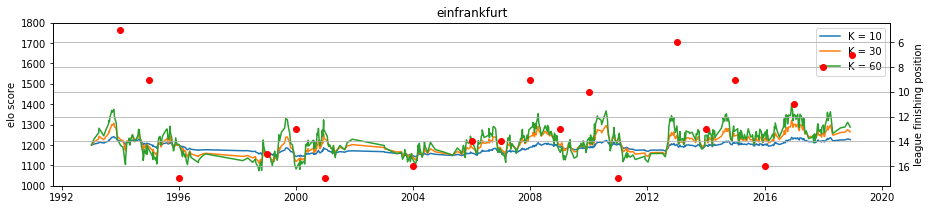

In [19]:
team = 'einfrankfurt'
fig, ax = plt.subplots(figsize=(15,3))

ax.plot(match_dates[team], np.array(elo_10_ratings[team][:-1]), label='K = 10')
ax.plot(match_dates[team], np.array(elo_30_ratings[team][:-1]), label='K = 30')#

ax.plot(match_dates[team], np.array(elo_60_ratings[team][:-1]), label='K = 60')

ax1 = plt.twinx(ax)
ax1.plot(years, get_standings(team), 'ro')
ax1.invert_yaxis()
ax1.set_ylabel('league finishing position')
ax.set_ylabel('elo score')

ax.set_ylim(1000, 1800)

plt.grid()
ax.legend()
_ = plt.title(team)

EF won 28.95% of the games and 21.05% ended in a draw.


Text(0.5, 1.0, 'Eintracht win probability vs Bayern, based on Elo')

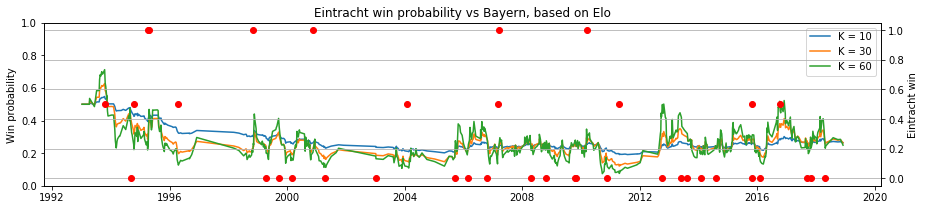

In [20]:
# this part of the code is fairly specific for bayern/eintracht, but easy to abstract if needed...

# computes the expected win probability from elo ratings
def expect(ratings, alg):
    R_E = ratings['einfrankfurt']
    R_B = ratings['bayernmunich']
    E = []
    for r1, r2 in zip(R_E, R_B):
        E.append(alg.expect(r1, r2))
    return E

# get all dataframe rows where bayern and eintracht faced off
teams_played = bl.loc[[i for i in participation['einfrankfurt'] if i in participation['bayernmunich']]]

# get win percentage
draw = teams_played.draw.sum()
bm_win = teams_played.winner.value_counts()['bayernmunich'] - draw
bm_loss = len(teams_played) - bm_win - draw
print('EF won {:.2f}% of the games and {:.2f}% ended in a draw.'.format(100*bm_loss/len(teams_played), 100*draw/len(teams_played)))

# insert numeric winner in the dataframe
teams_played['ef_win'] = 0
teams_played.ef_win += np.where(teams_played.loser=='bayernmunich', 1, 0) * (np.ones(len(teams_played)) - teams_played.draw)
teams_played.ef_win += 0.5 * teams_played.draw

# calculate and plot expected win probability and actual winner
fig, ax = plt.subplots(figsize=(15,3))
for ratings, alg, label in zip([elo_10_ratings, elo_30_ratings, elo_60_ratings], [Elo_10, Elo_30, Elo_60], [' 10', ' 30', ' 60']):
    ax.plot(match_dates['einfrankfurt'], expect(ratings, alg)[:-1], label='K ='+label)
ax.legend()
ax.set_ylim(0,1)
ax2 = ax.twinx()
ax2.plot(teams_played.Date, teams_played.ef_win, 'ro')
ax2.set_ylabel('Eintracht win')
ax.set_ylabel('Win probability')
plt.grid()
plt.title('Eintracht win probability vs Bayern, based on Elo')

## Glicko

To calculate Elo we could just go through the data line by line. For Glicko we are dealing with rating periods, so the calculation becomes more complex. The Glicko2 package does not take care of that for us.

In [21]:
# set up two Glicko 2 modules, one with sort of high sigma/tau values, one with low ones
tau_high = 1.2
sigma_high = .15
tau_low = .2
sigma_low = .06
# for some reason sublee refers to RD as phi in his code, even though phi is rescaled RD in the paper
Glicko_high = GLICKO(mu=1500, phi=350, tau=tau_high, sigma=sigma_high)
Glicko_low = GLICKO(mu=1500, phi=350, tau=tau_low, sigma=sigma_low)

In [22]:
# returns the lowest confidence interval mu - 2*RD
def apply_confidence_glicko(glicko_rating):
    skill = []
    for r in glicko_rating:
        skill.append(r.mu - 2*r.phi)
    return np.array(skill)

In [23]:
def construct_series(subdat, team, ratings):
    # helper function to construct a series from a dataframe for a team
    # get all matches played by the team
    relevant = subdat[(subdat.HomeTeam == team) | (subdat.AwayTeam == team)]
    # rewrite the matches in the format taken by the algroithm, which is [(result, opponent_rating)]
    series = []
    for idx, row in relevant.iterrows():
        home_win, draw = get_matchup(row)
        if team == row.HomeTeam:
            opponent_rating = ratings[row.AwayTeam][-1]
        else:
            opponent_rating = ratings[row.HomeTeam][-1]
        if row.draw:
            series.append((0.5, opponent_rating))
        elif row.winner == team:
            series.append((1, opponent_rating))
        else:
            series.append((0, opponent_rating))
    return series

In [24]:
# the code below is used to calculate the glicko ratings with one day set as rating period
# this is against the idea of glicko that 10-15 matches per team should be in the rating period

match_days = set(bl.Date) # need this to allow timestamp comparison
day_delta = datetime.timedelta(days=1)
start_date = bl.Date.min()
end_date = bl.Date.max() + day_delta
    
def get_daily_ratings(calc, ratings):
    # since no team plays twice on the same day, we don't need to worry about series, 
    # but we still need to increase uncertainty on days without matches
    # of course the entire idea of using a day as series is not in the spirit of G2
    day_range = []
    for i in range((end_date - start_date).days):
        date = start_date + i * day_delta
        day_range.append(date)
        if date in match_days:
            # if there were matches on this date, get the teams that have played and update their ratings
            subdat = bl[bl.Date == date]
            teams_played = set(list(subdat.HomeTeam) + list(subdat.AwayTeam))
            for idx, row in subdat.iterrows():
                winner_is_home, draw = get_matchup(row)
                if winner_is_home:
                    winner = row.HomeTeam
                    loser = row.AwayTeam
                else:
                    winner = row.AwayTeam
                    loser = row.HomeTeam
                update_ratings(calc, ratings, winner, loser, draw)
            teams_not_played = [i for i in teams if i not in teams_played]
        else:
            teams_not_played = teams
        # for the teams who did not play, we only need to update their RD based on the volatility
        for team in teams_not_played:
            rating = ratings[team][-1]
            phi_star = np.sqrt(rating.phi ** 2 + rating.sigma ** 2)
            new_rating = calc.create_rating(rating.mu, phi_star, rating.sigma)
            ratings[team].append(new_rating)
    return ratings, day_range

In [64]:
# this code is used to calculate the glicko ratings with 30 days set as rating period

def get_monthly_ratings(calc, ratings):
    months = []
    # group datafame by month and year and iterate over groups
    grouped =  bl.groupby([bl.Date.dt.year, bl.Date.dt.month])
    for year in range(bl.Date.dt.year.min(), bl.Date.dt.year.max()+1):
        for month in range(1, 13):
            months.append(pd.Timestamp(year, month, 1, 0))
            try:
                subdat = grouped.get_group((year, month))
                # each team gets an updated ratind for the month, but this rating cannot be used
                # for rating other teams in the same month, hence we keep it as provisional for now
                provisional_ratings = {}
                # now go through our list of teams and get their series = all the matches they had in
                # the month
                teams_played = set(list(subdat.HomeTeam) + list(subdat.AwayTeam))
                for team in teams_played:
                    old_rating = ratings[team][-1]
                    series = construct_series(subdat, team, ratings)
                    new_rating = calc.rate(old_rating, series)
                    provisional_ratings[team] = new_rating
                teams_not_played = [i for i in teams if i not in teams_played]                
            except KeyError as e:
                # no matches were played that month
                teams_not_played = teams
            # for the teams who did not play, we only need to update their RD based on the volatility
            for team in teams_not_played:
                rating = ratings[team][-1]
                phi = rating.phi / 173.7178
                phi_star = np.sqrt(phi ** 2 + rating.sigma ** 2)
                new_rating = calc.create_rating(rating.mu, phi_star * 173.7178, rating.sigma)
                provisional_ratings[team] = new_rating
            for k, v in provisional_ratings.items():
                ratings[k].append(v)
    return ratings, months

In [69]:
# this code is used to calculate the glicko ratings with one BL season set as rating period

# for plots, this used to be the first date of the season, which made less sense. hence the name...
season_start_date = bl.groupby('Season').last().Date

def get_seasonal_ratings(calc, ratings):
    for season in seasons:
        seasonal = bl[bl.Season == season]
        # each team gets an updated ratind for the season, but this rating cannot be used
        # for rating other teams in the same season, hence we keep it as provisional for now
        provisional_ratings = {}
        # now go through our list of teams and get their series = all the matches they had in
        # the season
        for team in teams:
            old_rating = ratings[team][-1]
            series = construct_series(seasonal, team, ratings)
            if len(series) > 0:
                new_rating = calc.rate(old_rating, series)
            else:
                # if the team didn't play that season, the series will be empty
                # the glicko implementation breaks here, so we fix it directly
                # only step 6 of the algorithm should be applied => increase phi
                # this should not be necessary once my PR is accepted by sublee
                phi = old_rating.phi / 173.7178
                phi_star = np.sqrt(phi ** 2 + old_rating.sigma ** 2)
                new_rating = calc.create_rating(old_rating.mu, phi_star * 173.7178, old_rating.sigma)
            provisional_ratings[team] = new_rating
        for k, v in provisional_ratings.items():
            ratings[k].append(v)
    return ratings

In [66]:
# calculate monthly ratings
gm_ratings_high = defaultdict(list)
for team in teams:
    gm_ratings_high[team].append(Glicko_high.create_rating(mu=1500, phi=350))
    
gm_ratings_low = defaultdict(list)
for team in teams:
    gm_ratings_low[team].append(Glicko_low.create_rating(mu=1500, phi=350))

gm_ratings_high, _ = get_monthly_ratings(Glicko_high, gm_ratings_high)
gm_ratings_low, month_range = get_monthly_ratings(Glicko_low, gm_ratings_low)

In [67]:
# calculate daily ratings
gl_ratings_high = defaultdict(list)
for team in teams:
    gl_ratings_high[team].append(Glicko_high.create_rating(mu=1500, phi=350))

gl_ratings_low = defaultdict(list)
for team in teams:
    gl_ratings_low[team].append(Glicko_low.create_rating(mu=1500, phi=350))

gl_ratings_high, _ = get_daily_ratings(Glicko_high, gl_ratings_high)
gl_ratings_low, day_range = get_daily_ratings(Glicko_low, gl_ratings_low)

In [70]:
# calculate seasonal ratings
seasons = bl.Season.unique()
gs_ratings_high = defaultdict(list)
for team in teams:
    gs_ratings_high[team].append(Glicko_high.create_rating(mu=1500, phi=350))

gs_ratings_low = defaultdict(list)
for team in teams:
    gs_ratings_low[team].append(Glicko_low.create_rating(mu=1500, phi=350))

gs_ratings_high = get_seasonal_ratings(Glicko_high, gs_ratings_high)
gs_ratings_low = get_seasonal_ratings(Glicko_low, gs_ratings_low)

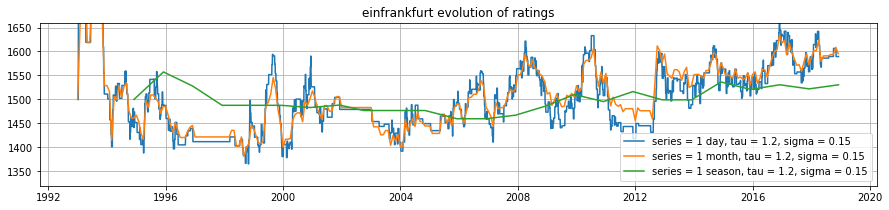

In [71]:
# plot season and day wide glicko
team = 'einfrankfurt'
plt.figure(figsize=(15,3))

#plt.plot(match_dates[team], elo_30_ratings[team][:-1], label='elo 32')
plt.plot(day_range, [i.mu for i in gl_ratings_high[team][:-1]], label='series = 1 day, tau = {}, sigma = {}'.format(tau_high, sigma_high))
#plt.plot(day_range, [i.mu for i in gl_ratings_low[team][:-1]], label='series = 1 day, tau = {}, sigma = {}'.format(tau_low, sigma_low))
plt.plot(month_range, [i.mu for i in gm_ratings_high[team][:-1]], label='series = 1 month, tau = {}, sigma = {}'.format(tau_high, sigma_high))
#plt.plot(month_range, [i.mu for i in gm_ratings_low[team][:-1]], label='series = 1 month, tau = {}, sigma = {}'.format(tau_low, sigma_low))
plt.plot(season_start_date, [i.mu for i in gs_ratings_high[team][:-1]], '-', label='series = 1 season, tau = {}, sigma = {}'.format(tau_high, sigma_high))
#plt.plot(season_start_date, [i.mu for i in gs_ratings_low[team][:-1]], '-o', label='series = 1 season, tau = {}, sigma = {}'.format(tau_low, sigma_low))
#plt.ylim(min([i.mu for i in gs_ratings_high[team]])-100, max([i.mu for i in gm_ratings_high[team]])+100)
plt.ylim(1320, 1660)
plt.grid()
plt.legend(loc='lower right')
_ = plt.title(team + ' evolution of ratings')

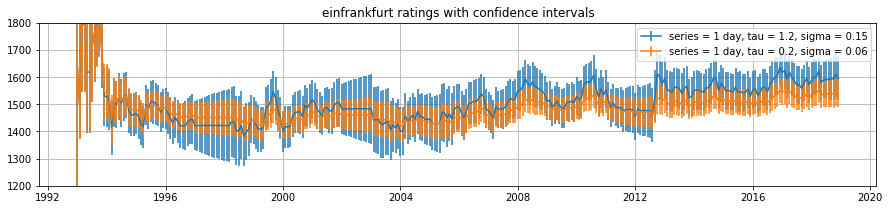

In [88]:
# plot season and day wide glicko
team = 'einfrankfurt'
plt.figure(figsize=(15,3))

#plt.plot(match_dates[team], elo_30_ratings[team][:-1], label='elo 32')
plt.errorbar(month_range, [i.mu for i in gm_ratings_high[team][:-1]], yerr=[i.phi for i in gm_ratings_high[team][:-1]], errorevery=1, label='series = 1 day, tau = {}, sigma = {}'.format(tau_high, sigma_high))
plt.grid()
plt.errorbar(month_range, [i.mu for i in gm_ratings_low[team][:-1]], yerr=[i.phi for i in gm_ratings_low[team][:-1]], errorevery=1, label='series = 1 day, tau = {}, sigma = {}'.format(tau_low, sigma_low))
plt.ylim(1200, 1800)
plt.legend()
_ = plt.title(team + ' ratings with confidence intervals')

Text(0, 0.5, 'sigma')

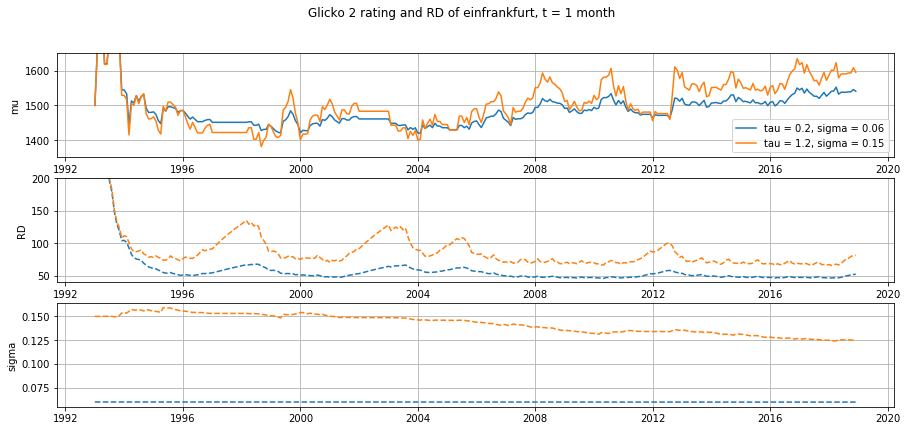

In [85]:
team = "einfrankfurt"
fig, axs = plt.subplots(3, figsize=(15,6.5))
fig.suptitle('Glicko 2 rating and RD of {}, t = 1 month'.format(team))
axs[0].plot(month_range, np.array([i.mu for i in gm_ratings_low[team][:-1]]), label='tau = {}, sigma = {}'.format(tau_low, sigma_low))
axs[1].plot(month_range, np.array([i.phi for i in gm_ratings_low[team][:-1]]), '--')
axs[0].plot(month_range, np.array([i.mu for i in gm_ratings_high[team][:-1]]), label='tau = {}, sigma = {}'.format(tau_high, sigma_high))
axs[1].plot(month_range, np.array([i.phi for i in gm_ratings_high[team][:-1]]), '--')
axs[1].set_ylim(40, 200)
axs[0].set_ylim(1350,1650)
axs[0].set_ylabel('mu')
axs[1].set_ylabel('RD')
axs[0].grid()
axs[1].grid()
axs[0].legend()
axs[2].plot(month_range, np.array([i.sigma for i in gm_ratings_low[team][:-1]]), '--')
axs[2].plot(month_range, np.array([i.sigma for i in gm_ratings_high[team][:-1]]), '--')
axs[2].grid()
axs[2].set_ylabel('sigma')


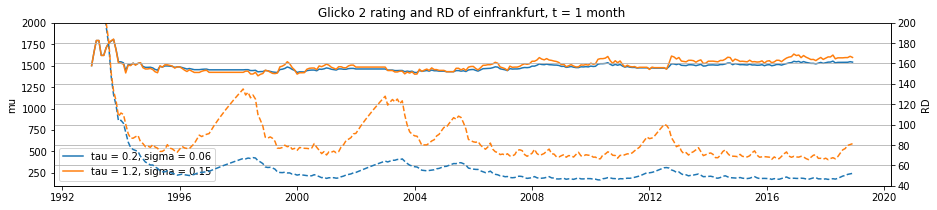

In [84]:
# plot mu and rd for Bayern and Eintracht daily

team = 'einfrankfurt'
fix, ax1 = plt.subplots(figsize=(15,3))
ax2 = ax1.twinx()
ax1.plot(month_range, np.array([i.mu for i in gm_ratings_low[team][:-1]]), label='tau = {}, sigma = {}'.format(tau_low, sigma_low))
ax2.plot(month_range, np.array([i.phi for i in gm_ratings_low[team][:-1]]), '--')

ax1.plot(month_range, np.array([i.mu for i in gm_ratings_high[team][:-1]]), label='tau = {}, sigma = {}'.format(tau_high, sigma_high))
ax2.plot(month_range, np.array([i.phi for i in gm_ratings_high[team][:-1]]), '--')

ax2.set_ylim(40,200)
ax1.set_ylim(100, 2000)
ax1.legend()
#ax2.legend()
ax2.set_ylabel('RD')
ax1.set_ylabel('mu')
plt.grid()
_ = plt.title('Glicko 2 rating and RD of {}, t = 1 month'.format(team))

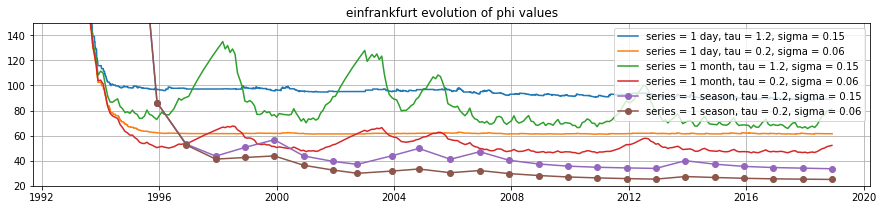

In [75]:
# plot season and day wide glicko phi
team = 'einfrankfurt'
plt.figure(figsize=(15,3))

#plt.plot(match_dates[team], elo_30_ratings[team][:-1], label='elo 32')
plt.plot(day_range, [i.phi for i in gl_ratings_high[team][:-1]], label='series = 1 day, tau = {}, sigma = {}'.format(tau_high, sigma_high))
plt.grid()
plt.plot(day_range, [i.phi for i in gl_ratings_low[team][:-1]], label='series = 1 day, tau = {}, sigma = {}'.format(tau_low, sigma_low))
plt.plot(month_range, [i.phi for i in gm_ratings_high[team][:-1]], label='series = 1 month, tau = {}, sigma = {}'.format(tau_high, sigma_high))
plt.plot(month_range, [i.phi for i in gm_ratings_low[team][:-1]], label='series = 1 month, tau = {}, sigma = {}'.format(tau_low, sigma_low))

plt.plot(season_start_date, [i.phi for i in gs_ratings_high[team][:-1]], '-o', label='series = 1 season, tau = {}, sigma = {}'.format(tau_high, sigma_high))
plt.plot(season_start_date, [i.phi for i in gs_ratings_low[team][:-1]], '-o', label='series = 1 season, tau = {}, sigma = {}'.format(tau_low, sigma_low))

plt.ylim(20, 150)


plt.legend()
_ = plt.title(team + ' evolution of phi values')

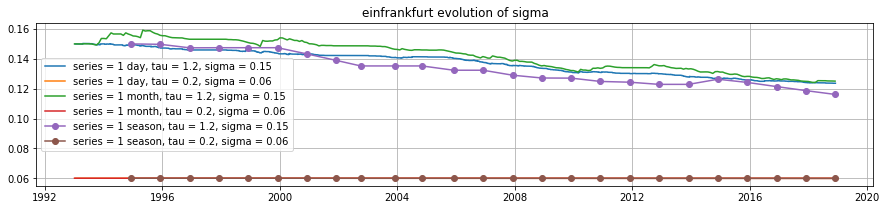

In [76]:
# plot season and day wide glicko sigma
team = 'einfrankfurt'
plt.figure(figsize=(15,3))

#plt.plot(match_dates[team], elo_30_ratings[team][:-1], label='elo 32')
plt.plot(day_range, [i.sigma for i in gl_ratings_high[team][:-1]], label='series = 1 day, tau = {}, sigma = {}'.format(tau_high, sigma_high))
plt.grid()
plt.plot(day_range, [i.sigma for i in gl_ratings_low[team][:-1]], label='series = 1 day, tau = {}, sigma = {}'.format(tau_low, sigma_low))
plt.plot(month_range, [i.sigma for i in gm_ratings_high[team][:-1]], label='series = 1 month, tau = {}, sigma = {}'.format(tau_high, sigma_high))
plt.plot(month_range, [i.sigma for i in gm_ratings_low[team][:-1]], label='series = 1 month, tau = {}, sigma = {}'.format(tau_low, sigma_low))
plt.plot(season_start_date, [i.sigma for i in gs_ratings_high[team][:-1]], '-o', label='series = 1 season, tau = {}, sigma = {}'.format(tau_high, sigma_high))
plt.plot(season_start_date, [i.sigma for i in gs_ratings_low[team][:-1]], '-o', label='series = 1 season, tau = {}, sigma = {}'.format(tau_low, sigma_low))

plt.legend()
_ = plt.title(team + ' evolution of sigma')

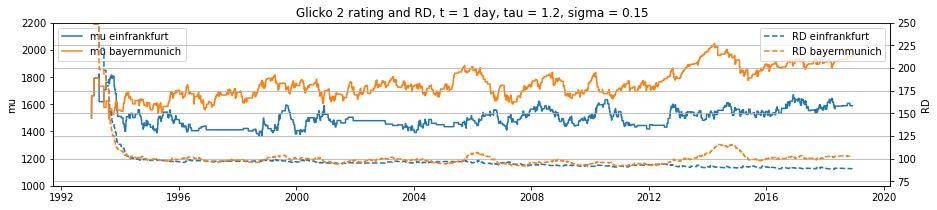

In [77]:
# plot mu and rd for Bayern and Eintracht daily

team = 'einfrankfurt'
fix, ax1 = plt.subplots(figsize=(15,3))
ax2 = ax1.twinx()
ax1.plot(day_range, np.array([i.mu for i in gl_ratings_high[team][:-1]]), label='mu ' + team)
ax2.plot(day_range, np.array([i.phi for i in gl_ratings_high[team][:-1]]), '--', label='RD ' + team)

team = 'bayernmunich'
ax1.plot(day_range, np.array([i.mu for i in gl_ratings_high[team][:-1]]), label='mu ' + team)
ax2.plot(day_range, np.array([i.phi for i in gl_ratings_high[team][:-1]]), '--', label='RD ' + team)

ax2.set_ylim(70,250)
ax1.set_ylim(1000, 2200)
ax1.legend()
ax2.legend()
ax2.set_ylabel('RD')
ax1.set_ylabel('mu')
plt.grid()
_ = plt.title('Glicko 2 rating and RD, t = 1 day, tau = {}, sigma = {}'.format(tau_high, sigma_high))

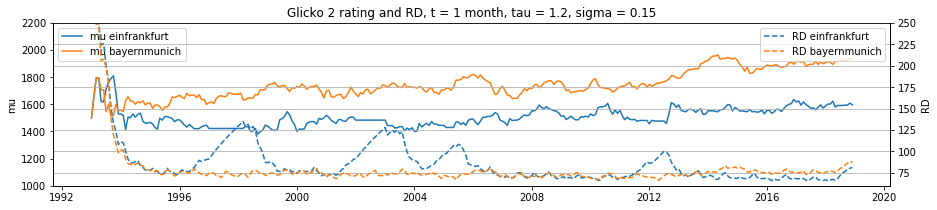

In [78]:
# plot mu and rd for Bayern and Eintracht monthly

team = 'einfrankfurt'
fix, ax1 = plt.subplots(figsize=(15,3))
ax2 = ax1.twinx()
ax1.plot(month_range, np.array([i.mu for i in gm_ratings_high[team][:-1]]), label='mu ' + team)
ax2.plot(month_range, np.array([i.phi for i in gm_ratings_high[team][:-1]]), '--', label='RD ' + team)

team = 'bayernmunich'
ax1.plot(month_range, np.array([i.mu for i in gm_ratings_high[team][:-1]]), label='mu ' + team)
ax2.plot(month_range, np.array([i.phi for i in gm_ratings_high[team][:-1]]), '--', label='RD ' + team)

ax2.set_ylim(60,250)
ax1.set_ylim(1000, 2200)
ax1.legend()
ax2.legend()
ax2.set_ylabel('RD')
ax1.set_ylabel('mu')
plt.grid()
_ = plt.title('Glicko 2 rating and RD, t = 1 month, tau = {}, sigma = {}'.format(tau_high, sigma_high))

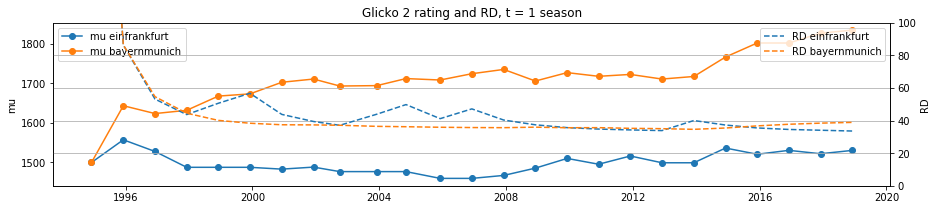

In [79]:
# plot mu and rd for Bayern and Eintracht seasonal
team = 'einfrankfurt'
fix, ax1 = plt.subplots(figsize=(15,3))
ax2 = ax1.twinx()
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings_high[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.phi for i in gs_ratings_high[team][:-1]]), '--', label='RD ' + team)

team = 'bayernmunich'
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings_high[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.phi for i in gs_ratings_high[team][:-1]]), '--', label='RD ' + team)

plt.grid()
ax2.set_ylabel('RD')
ax1.set_ylabel('mu')
ax2.set_ylim(0,100)

ax1.legend()
ax2.legend()
_ = plt.title('Glicko 2 rating and RD, t = 1 season')

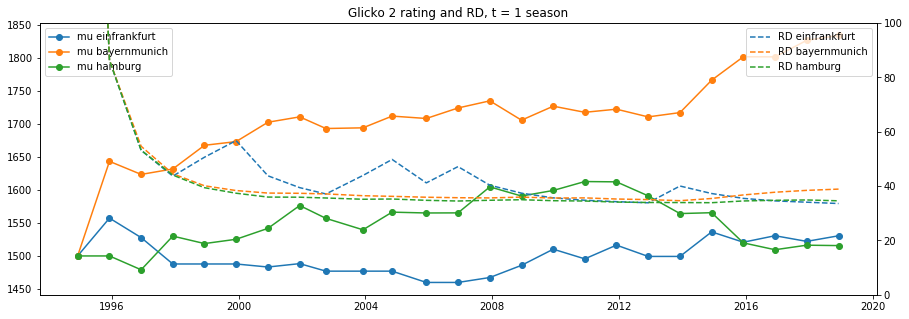

In [80]:
# plot mu and rd
team = 'einfrankfurt'
fix, ax1 = plt.subplots(figsize=(15,5))
ax2 = ax1.twinx()
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings_high[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.phi for i in gs_ratings_high[team][:-1]]), '--', label='RD ' + team)

team = 'bayernmunich'
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings_high[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.phi for i in gs_ratings_high[team][:-1]]), '--', label='RD ' + team)

team = 'hamburg'
ax1.plot(season_start_date, np.array([i.mu for i in gs_ratings_high[team][:-1]]), '-o', label='mu ' + team)
ax2.plot(season_start_date, np.array([i.phi for i in gs_ratings_high[team][:-1]]), '--', label='RD ' + team)

ax2.set_ylim(0, 100)

ax1.legend()
ax2.legend()
_ = plt.title('Glicko 2 rating and RD, t = 1 season')

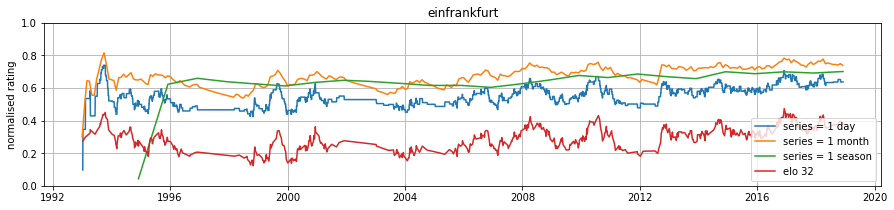

In [89]:
# plot normalised season and day wide glicko and elo for comparison
# what we see is that even if normalized these values aren't comparable
team = 'einfrankfurt'
plt.figure(figsize=(15,3))
glicko_conf = dict(zip(teams, [apply_confidence_glicko(gl_ratings_high[i]) for i in teams]))
plt.plot(day_range, normalize(glicko_conf, team)[:-1], label='series = 1 day')
glicko_conf = dict(zip(teams, [apply_confidence_glicko(gm_ratings_high[i]) for i in teams]))
plt.plot(month_range, normalize(glicko_conf, team)[:-1], '-', label='series = 1 month')
glicko_conf = dict(zip(teams, [apply_confidence_glicko(gs_ratings_high[i]) for i in teams]))
plt.plot(season_start_date, normalize(glicko_conf, team)[:-1], '-', label='series = 1 season')
plt.plot(match_dates[team], normalize(elo_30_ratings, team)[:-1], label='elo 32')
plt.ylim(0,1)
plt.grid()
plt.ylabel('normalised rating')
plt.legend()
_ = plt.title(team)

In [82]:
def predict_glicko_winner(calc, r1, r2):
    r1_g2 = calc.scale_down(r1)
    r2_g2 = calc.scale_down(r2)
    # equivalent to calling Glicko.reduce_impact
    g = 1 / np.sqrt(1+3*r1_g2.phi **2 / np.pi**2)
    # equivalent to calling Glicko.expect_score
    E = 1 / (1 + np.exp(-g * (r1_g2.mu - r2_g2.mu)))
    return E
    
# wrapper to call the above function with different dictionaries/classes
def predict_glicko_winners(ratings, calc, team1, team2):
    preds = []
    for r1, r2 in zip(ratings[team1], ratings[team2]):
        preds.append(predict_glicko_winner(calc, r1, r2))
    return preds

EF won 28.95% of the games and 21.05% ended in a draw.


Text(0.5, 1.0, 'Eintracht win probability vs Bayern, based on Glicko-2')

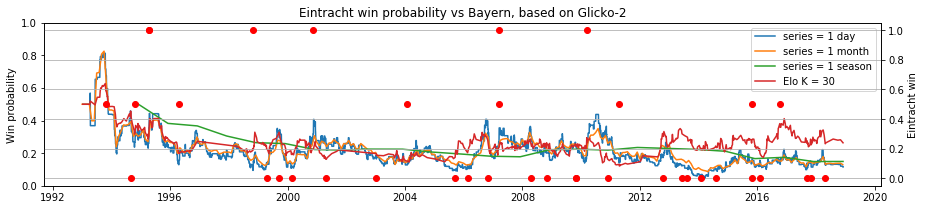

In [83]:
# make a nice plot of win probabilities like the one we did for elo
teams_played = bl.loc[[i for i in participation['einfrankfurt'] if i in participation['bayernmunich']]]
draw = teams_played.draw.sum()
bm_win = teams_played.winner.value_counts()['bayernmunich'] - draw
bm_loss = len(teams_played) - bm_win - draw
print('EF won {:.2f}% of the games and {:.2f}% ended in a draw.'.format(100*bm_loss/len(teams_played), 100*draw/len(teams_played)))

teams_played['ef_win'] = 0
teams_played.ef_win += np.where(teams_played.loser=='bayernmunich', 1, 0) * (np.ones(len(teams_played)) - teams_played.draw)
teams_played.ef_win += 0.5 * teams_played.draw
fig, ax = plt.subplots(figsize=(15,3))

preds = predict_glicko_winners(gl_ratings_high, Glicko_high, 'einfrankfurt', 'bayernmunich')
ax.plot(day_range, preds[:-1], label='series = 1 day')

#preds = predict_glicko(gl_ratings_low, Glicko_low, 'einfrankfurt', 'bayernmunich')
#ax.plot(day_range, preds[:-1])

preds = predict_glicko_winners(gm_ratings_high, Glicko_high, 'einfrankfurt', 'bayernmunich')
ax.plot(month_range, preds[:-1], label='series = 1 month')

preds = predict_glicko_winners(gs_ratings_high, Glicko_high, 'einfrankfurt', 'bayernmunich')
ax.plot(season_start_date, preds[:-1], '-', label='series = 1 season')

#preds = predict_glicko(gs_ratings_low, Glicko_low, 'einfrankfurt', 'bayernmunich')
#ax.plot(season_start_date, preds[:-1])

ax.plot(match_dates['einfrankfurt'], expect(elo_30_ratings, Elo_30)[:-1], label='Elo K = 30')


ax.legend()
ax.set_ylim(0,1)
ax2 = ax.twinx()
ax2.plot(teams_played.Date, teams_played.ef_win, 'ro')

ax2.set_ylabel('Eintracht win')
ax.set_ylabel('Win probability')
plt.grid()
plt.title('Eintracht win probability vs Bayern, based on Glicko-2')

# bayern has won the last three matches against EF pretty convincingly but won DFB-Pokal, which is not in the dataset!

## Trueskill 

In [43]:
ts_calc = ts.TrueSkill(backend='scipy')

In [44]:
# probably won't have time for this in the presentation, but for the sake of completenes...
ts_ratings = defaultdict(list)
for team in teams:
    ts_ratings[team].append(ts_calc.Rating(mu=25.0, sigma=8.33))

In [45]:
# go through the dataframe row by row and update the rating dictionaries
for idx, row in bl.iterrows():
    winner_is_home, draw = get_matchup(row)
    if winner_is_home:
        winner = row.HomeTeam
        loser = row.AwayTeam
    else:
        winner = row.AwayTeam
        loser = row.HomeTeam
    winner_new, loser_new = ts_calc.rate_1vs1(ts_ratings[winner][-1], ts_ratings[loser][-1], drawn=draw)
    ts_ratings[winner].append(winner_new)
    ts_ratings[loser].append(loser_new)

In [46]:
import itertools
def win_probability(team1, team2):
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    BETA = ts.BETA
    denom = np.sqrt(size * (BETA * BETA) + sum_sigma)
    return ts_calc.cdf(delta_mu / denom)

In [47]:
p_draw = bl.draw.sum() / len(bl)
beta = 8.333 / 2
from scipy.stats import norm

def win_probability(r1, r2):
    delta_mu = r1.mu - r2.mu
    sigmas = np.array([r1.sigma, r2.sigma, np.sqrt(2)*beta])
    p_1 = norm.cdf(delta_mu / np.linalg.norm(sigmas))
    p_2 = 1 - p_1
    return p_1, p_2, p_draw

def win_probabilities(ratings1, ratings2):
    probs = []
    for r1, r2 in zip(ratings1, ratings2):
        p1, p2, pd = win_probability(r1, r2)
        probs.append(p1)
    return probs    

EF won 28.95% of the games and 21.05% ended in a draw.


Text(0.5, 1.0, 'Eintracht win probability vs Bayern, based on Trueskill')

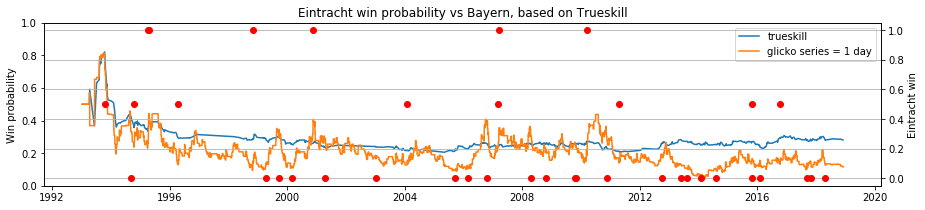

In [48]:
# make a nice plot of win probabilities like the one we did for elo
teams_played = bl.loc[[i for i in participation['einfrankfurt'] if i in participation['bayernmunich']]]
draw = teams_played.draw.sum()
bm_win = teams_played.winner.value_counts()['bayernmunich'] - draw
bm_loss = len(teams_played) - bm_win - draw
print('EF won {:.2f}% of the games and {:.2f}% ended in a draw.'.format(100*bm_loss/len(teams_played), 100*draw/len(teams_played)))

teams_played['ef_win'] = 0
teams_played.ef_win += np.where(teams_played.loser=='bayernmunich', 1, 0) * (np.ones(len(teams_played)) - teams_played.draw)
teams_played.ef_win += 0.5 * teams_played.draw
fig, ax = plt.subplots(figsize=(15,3))

preds = win_probabilities(ts_ratings['einfrankfurt'], ts_ratings['bayernmunich'])
ax.plot(match_dates['einfrankfurt'], preds[:-1], label='trueskill')

preds = predict_glicko_winners(gl_ratings_high, Glicko_high, 'einfrankfurt', 'bayernmunich')
ax.plot(day_range, preds[:-1], label='glicko series = 1 day')



ax.legend()
ax.set_ylim(0,1)
ax2 = ax.twinx()
ax2.plot(teams_played.Date, teams_played.ef_win, 'ro')

ax2.set_ylabel('Eintracht win')
ax.set_ylabel('Win probability')
plt.grid()
plt.title('Eintracht win probability vs Bayern, based on Trueskill')